In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install pandas-ta

In [ ]:
import pandas as pd
import pandas_ta as ta
import numpy as np
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Masking
from tensorflow.keras.callbacks import EarlyStopping
from scipy.stats import pearsonr
import matplotlib.pyplot as plt


In [ ]:
df_parquet = pd.read_parquet('stock_data.parquet')

In [ ]:
df_parquet.head()

,time,ID,open,high,low,close,volume,target
0,2015-01-05,AAA,5.64,5.66,5.53,5.60,284100,0.041673
1,2015-01-05,ACB,2.82,2.80,2.76,2.80,55888,0.017575
2,2015-01-05,ANV,3.04,3.04,2.97,3.00,12400,0.057524
3,2015-01-05,ASM,3.86,4.03,3.86,3.94,2059650,0.033124
4,2015-01-05,BID,7.15,7.21,7.15,7.15,66380,0.053110


In [ ]:
df_parquet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137820 entries, 0 to 137819
Data columns (total 8 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   time    137820 non-null  datetime64[ns]
 1   ID      137820 non-null  object        
 2   open    137820 non-null  float64       
 3   high    137820 non-null  float64       
 4   low     137820 non-null  float64       
 5   close   137820 non-null  float64       
 6   volume  137820 non-null  int64         
 7   target  137820 non-null  float64       
dtypes: datetime64[ns](1), float64(5), int64(1), object(1)
memory usage: 8.4+ MB


In [ ]:
row_counts = df_parquet.groupby('ID').size()
count = len(row_counts)
print(count)
print(row_counts)

60
ID
AAA    2297
ACB    2297
ANV    2297
ASM    2297
BID    2297
BMP    2297
BSI    2297
BVH    2297
CII    2297
CMG    2297
CTD    2297
CTG    2297
DBC    2297
DGC    2297
DIG    2297
DPM    2297
DXG    2297
EIB    2297
FPT    2297
GAS    2297
GMD    2297
HAG    2297
HCM    2297
HDC    2297
HDG    2297
HPG    2297
HSG    2297
HT1    2297
IMP    2297
KBC    2297
KDC    2297
KDH    2297
MBB    2297
MSN    2297
MWG    2297
NKG    2297
NLG    2297
PAN    2297
PDR    2297
PHR    2297
PNJ    2297
PPC    2297
PTB    2297
PVD    2297
PVT    2297
REE    2297
SBT    2297
SHB    2297
SJS    2297
SSI    2297
STB    2297
TLG    2297
VCB    2297
VCG    2297
VHC    2297
VIC    2297
VIX    2297
VND    2297
VNM    2297
VSH    2297
dtype: int64


In [ ]:
features = []
for symb, df_symb in df_parquet.groupby('ID'):
    curr_symb_df['SMA_10'] = curr_symb_df.ta.sma(length=10)
    curr_symb_df['SMA_20'] = curr_symb_df.ta.sma(length=20)
    curr_symb_df['EMA_12'] = curr_symb_df.ta.ema(length=12)
    curr_symb_df['EMA_25'] = curr_symb_df.ta.ema(length=25)

    curr_symb_df['ADX'] = curr_symb_df.ta.adx()['ADX_14']

    curr_symb_df.dropna(inplace=True)

    features.append(curr_symb_df)

df_features = pd.concat(features)

In [ ]:
df_features.head()

,time,ID,open,high,low,close,volume,target,SMA_10,SMA_20,EMA_12,EMA_25,ADX
time,,,,,,,,,,,,,
2015-02-11,2015-02-11,AAA,5.27,5.26,5.18,5.23,240300,0.000000,5.270,5.3690,5.304556,5.427060,43.710581
2015-02-12,2015-02-12,AAA,5.27,5.31,5.26,5.27,102200,0.007561,5.258,5.3545,5.299240,5.414978,42.618613
2015-02-13,2015-02-13,AAA,5.27,5.31,5.23,5.27,223216,0.007561,5.258,5.3400,5.294741,5.403826,41.974935
2015-02-24,2015-02-24,AAA,5.31,5.38,5.30,5.31,101300,-0.007561,5.262,5.3300,5.297089,5.396609,40.069958
2015-02-25,2015-02-25,AAA,5.31,5.36,5.28,5.31,142100,0.036973,5.270,5.3240,5.299075,5.389947,38.623060


In [ ]:
train_df = df_features[df_features['time'] < '2022-01-01']
val_df = df_features[(df_features['time'] >= '2022-01-01') & (df_features['time'] < '2023-01-01')]
test_df = df_features[df_features['time']  >= '2023-01-01']

scaler = StandardScaler()
X_train = scaler.fit_transform(train_df[['open', 'high', 'low', 'close', 'volume','SMA_10', 'SMA_20', 'EMA_12', 'EMA_25', 'ADX']])
y_train = train_df['target'].values

X_val = scaler.transform(val_df[['open', 'high', 'low', 'close', 'volume','SMA_10', 'SMA_20', 'EMA_12', 'EMA_25', 'ADX']])
y_val = val_df['target'].values

X_test = scaler.transform(test_df[['open', 'high', 'low', 'close', 'volume','SMA_10', 'SMA_20', 'EMA_12', 'EMA_25', 'ADX']])
y_test = test_df['target'].values

def create_sequences(X, y, L):
    X_seq, y_seq = [], []
    for i in range(len(X) - L + 1):
        X_seq.append(X[i:i+L])
        y_seq.append(y[i+L-1])
    return np.array(X_seq), np.array(y_seq)

X_train_seq, y_train_seq = create_sequences(X_train, y_train, L)
X_val_seq, y_val_seq = create_sequences(X_val, y_val, L)
X_test_seq, y_test_seq = create_sequences(X_test, y_test, L)


In [ ]:
print(f"Train set: {len(train_df)}")
print(f"Validation set: {len(val_df)}")
print(f"Test set: {len(test_df)}")


Train set: 103260
Validation set: 15000
Test set: 17940


In [ ]:
L = 10
model = Sequential([
    Masking(mask_value=0.0, input_shape=(L, X_train.shape[1])),
    LSTM(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')

model.fit(X_train_seq, y_train_seq, epochs=10, validation_data=(X_val_seq, y_val_seq))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
3227/3227 ━━━━━━━━━━━━━━━━━━━━ 40s 12ms/step - loss: 0.0020 - val_loss: 0.0036
Epoch 2/10
3227/3227 ━━━━━━━━━━━━━━━━━━━━ 43s 12ms/step - loss: 0.0016 - val_loss: 0.0036
Epoch 3/10
3227/3227 ━━━━━━━━━━━━━━━━━━━━ 40s 12ms/step - loss: 0.0016 - val_loss: 0.0036
Epoch 4/10
3227/3227 ━━━━━━━━━━━━━━━━━━━━ 43s 12ms/step - loss: 0.0016 - val_loss: 0.0036
Epoch 5/10
3227/3227 ━━━━━━━━━━━━━━━━━━━━ 37s 11ms/step - loss: 0.0016 - val_loss: 0.0033
Epoch 6/10
3227/3227 ━━━━━━━━━━━━━━━━━━━━ 35s 11ms/step - loss: 0.0015 - val_loss: 0.0027
Epoch 7/10
3227/3227 ━━━━━━━━━━━━━━━━━━━━ 42s 11ms/step - loss: 0.0013 - val_loss: 0.0026
Epoch 8/10
3227/3227 ━━━━━━━━━━━━━━━━━━━━ 37s 12ms/step - loss: 0.0013 - val_loss: 0.0026
Epoch 9/10
3227/3227 ━━━━━━━━━━━━━━━━━━━━ 53s 15ms/step - loss: 0.0012 - val_loss: 0.0026
Epoch 10/10
3227/3227 ━━━━━━━━━━━━━━━━━━━━ 69s 11ms/step - loss: 0.0012 - val_loss: 0.0026


In [ ]:
y_pred = model.predict(X_test_seq).flatten()

pearson_results = []

for symb in test_df['ID'].unique():
    test_symb_df = test_df[test_df['ID'] == symb]

    relative_indices = np.where(test_df['ID'] == symb)[0] - (L - 1)

    y_test_symb = y_test_seq[relative_indices]
    y_pred_symb = y_pred[relative_indices]

    if len(y_test_symb) > 0 and len(y_pred_symb) > 0:
        pearson_corr, _ = pearsonr(y_test_symb, y_pred_symb)
        pearson_results.append(pearson_corr)
        print(f"Mã {symb}: Pearson Correlation = {pearson_corr}")

avg_pearson_corr = np.mean(pearson_results)
print(f"Pearson Correlation trung bình: {avg_pearson_corr}")

561/561 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step
Mã AAA: Pearson Correlation = 0.4623263857963536
Mã ACB: Pearson Correlation = 0.409675496583323
Mã ANV: Pearson Correlation = 0.5207717248825512
Mã ASM: Pearson Correlation = 0.5139450739522909
Mã BID: Pearson Correlation = 0.3927200905827155
Mã BMP: Pearson Correlation = 0.4833683905219274
Mã BSI: Pearson Correlation = 0.5208329099326462
Mã BVH: Pearson Correlation = 0.49633520862055996
Mã CII: Pearson Correlation = 0.49359288530683776
Mã CMG: Pearson Correlation = 0.46684570067179343
Mã CTD: Pearson Correlation = 0.4680371121004567
Mã CTG: Pearson Correlation = 0.4852028449141084
Mã DBC: Pearson Correlation = 0.4543554870392563
Mã DGC: Pearson Correlation = 0.5263888545235138
Mã DIG: Pearson Correlation = 0.5257781597672274
Mã DPM: Pearson Correlation = 0.4835883819022423
Mã DXG: Pearson Correlation = 0.4910332421812024
Mã EIB: Pearson Correlation = 0.48512735298190174
Mã FPT: Pearson Correlation = 0.51775920893583
Mã GAS: Pearson Correlation

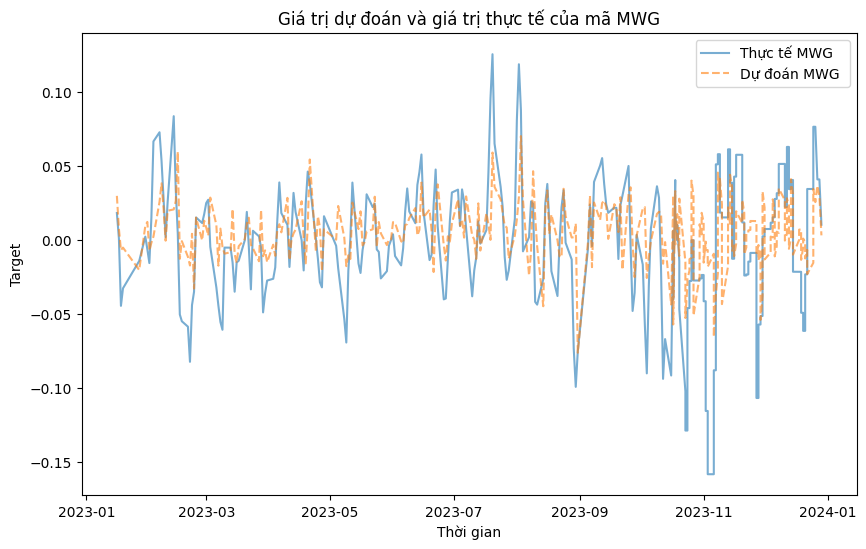

In [ ]:
symbol_code = 'MWG'

test_symb_df = test_df[test_df['ID'] == symbol_code]

relative_indices = np.where(test_df['ID'] == symbol_code)[0] - (L - 1)

y_test_symb = y_test_seq[relative_indices]
y_pred_symb = y_pred[relative_indices]

time_indices = test_symb_df['time'].iloc[L-1:].reset_index(drop=True)
min_length = min(len(time_indices), len(y_test_symb), len(y_pred_symb))

time_indices = time_indices[:min_length]
y_test_symb = y_test_symb[:min_length]
y_pred_symb = y_pred_symb[:min_length]

plt.figure(figsize=(10, 6))
plt.plot(time_indices, y_test_symb, label=f"Thực tế {symbol_code}", alpha=0.6)
plt.plot(time_indices, y_pred_symb, label=f"Dự đoán {symbol_code} ", linestyle='--', alpha=0.6)

plt.xlabel('Thời gian')
plt.ylabel('Target')
plt.title(f'Giá trị dự đoán và giá trị thực tế của mã {symbol_code}')
plt.legend()
plt.show()


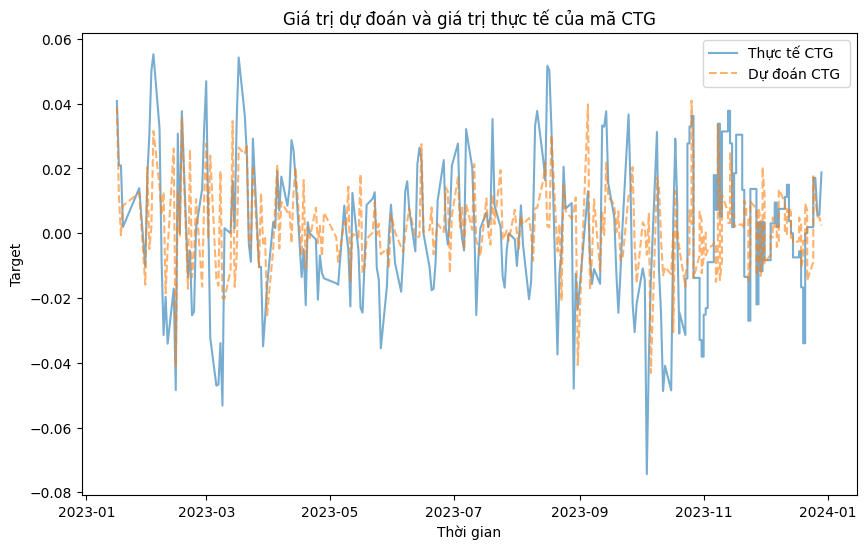

In [ ]:
symbol_code = 'CTG'

test_symb_df = test_df[test_df['ID'] == symbol_code]

relative_indices = np.where(test_df['ID'] == symbol_code)[0] - (L - 1)

y_test_symb = y_test_seq[relative_indices]
y_pred_symb = y_pred[relative_indices]

time_indices = test_symb_df['time'].iloc[L-1:].reset_index(drop=True)
min_length = min(len(time_indices), len(y_test_symb), len(y_pred_symb))

time_indices = time_indices[:min_length]
y_test_symb = y_test_symb[:min_length]
y_pred_symb = y_pred_symb[:min_length]

plt.figure(figsize=(10, 6))
plt.plot(time_indices, y_test_symb, label=f"Thực tế {symbol_code}", alpha=0.6)
plt.plot(time_indices, y_pred_symb, label=f"Dự đoán {symbol_code} ", linestyle='--', alpha=0.6)

plt.xlabel('Thời gian')
plt.ylabel('Target')
plt.title(f'Giá trị dự đoán và giá trị thực tế của mã {symbol_code}')
plt.legend()
plt.show()
